In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v003.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [ ]:
%autoreload
bioqic = mre_pinn.data.BIOQICPhantom('../data/BIOQIC/downloads')
bioqic.download()
bioqic.load_mat()
bioqic.preprocess()
dataset = bioqic.to_dataset()
dataset.save_xarrays('../data/BIOQIC/phantom')

In [3]:
example = mre_pinn.data.MREExample.load_xarrays('../data/BIOQIC/phantom', 80)
example.metadata

Loading ../data/BIOQIC/phantom/80/wave.nc
Loading ../data/BIOQIC/phantom/80/mre.nc
Loading ../data/BIOQIC/phantom/80/mre_mask.nc


size  spacing  origin   limit   center  extent
variable dimension                                                
wave     x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375
mre      x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375
mre_mask x           128   0.0015     0.0  0.1905  0.09525  0.1920
         y            80   0.0015     0.0  0.1185  0.05925  0.1200
         z            25   0.0015     0.0  0.0360  0.01800  0.0375

In [4]:
example.describe()

dtype     count                     mean  \
variable component                                                  
wave     z          complex128  256000.0  -0.00007800+0.00006700j   
         x          complex128  256000.0   0.00011600+0.00006000j   
         y          complex128  256000.0   0.00013000-0.00060200j   
mre      scalar     complex128  256000.0  5787.606492+212.755895j   
mre_mask scalar          int64  256000.0   0.61056600+0.00000000j   

                            std                 min                 25%  \
variable component                                                        
wave     z             0.005825 -0.023770+0.001962j -0.002346+0.004141j   
         x             0.006573 -0.021751+0.006846j -0.002244+0.001933j   
         y             0.014630 -0.027802+0.003952j -0.004819+0.001928j   
mre      scalar     5379.844267  0.000000+0.000000j  0.000000+0.000000j   
mre_mask scalar        0.650332  0.000000+0.000000j  0.000000+0.000000j   

                                         50%                       75%  \
variable component                                                       
wave     z         -0.000196000+0.001563000j  0.002125000-0.001518000j   
         x          0.000128000+0.001510000j  0.002530000-0.001175000j   
         y          0.000387000+0.002111000j  0.005085000+0.003413000j   
mre      scalar     10097.662129+358.617637j  10097.662129+358.617637j   
mre_mask scalar     1.000000000+0.000000000j  1.000000000+0.000000000j   

                                          max  
variable component                             
wave     z           0.023069000+0.003372000j  
         x           0.022795000-0.007461000j  
         y           0.028941000-0.005118000j  
mre      scalar     35183.797846+2546.696361j  
mre_mask scalar      5.000000000+0.000000000j

<IPython.core.display.Javascript object>


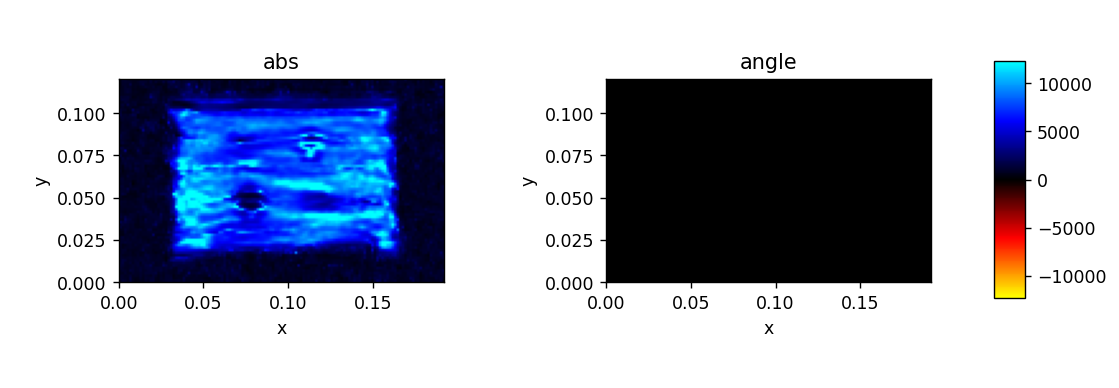

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [5]:
%autoreload
example.eval_baseline(frequency=example.wave.frequency.item(), polar=True)
example.view('base', ax_height=2, ax_width=3, col='part', polar=True)

In [6]:
pde = mre_pinn.pde.WaveEquation.from_name('hetero', omega=example.wave.frequency.item(), detach=True)

In [12]:
%autoreload
pinn = mre_pinn.model.MREPINN(
    example,
    omega=30,
    n_layers=5,
    n_hidden=128,
    polar_input=False,
    conditional=False
)
pinn

MREPINN(
  (u_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=6, bias=True)
  )
  (mu_pinn): PINN(
    (hidden0): Linear(in_features=3, out_features=128, bias=True)
    (hidden1): Linear(in_features=131, out_features=128, bias=True)
    (hidden2): Linear(in_features=259, out_features=128, bias=True)
    (hidden3): Linear(in_features=387, out_features=128, bias=True)
    (output): Linear(in_features=515, out_features=2, bias=True)
  )
)

In [13]:
%autoreload
model = mre_pinn.training.MREPINNModel(
    example, pinn, pde,
    loss_weights=[1, 0, 1e-10],
    pde_warmup_iters=5000,
    pde_step_iters=5000,
    pde_init_weight=1e-12,
    n_points=1024
)
model.compile(optimizer='adam', lr=1e-4, loss=mre_pinn.training.losses.msae_loss)

Compiling model...
'compile' took 0.000188 s



In [14]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
model.benchmark(100)

# iterations: 100
Data time/iter:  0.0015s (2.54%)
Model time/iter: 0.0007s (1.15%)
Loss time/iter:  0.0568s (96.31%)
Total time/iter: 0.0590s
Total time: 5.8997s
1k iters time: 0.98m
10k iters time: 9.83m
100k iters time: 1.64h


<IPython.core.display.Javascript object>


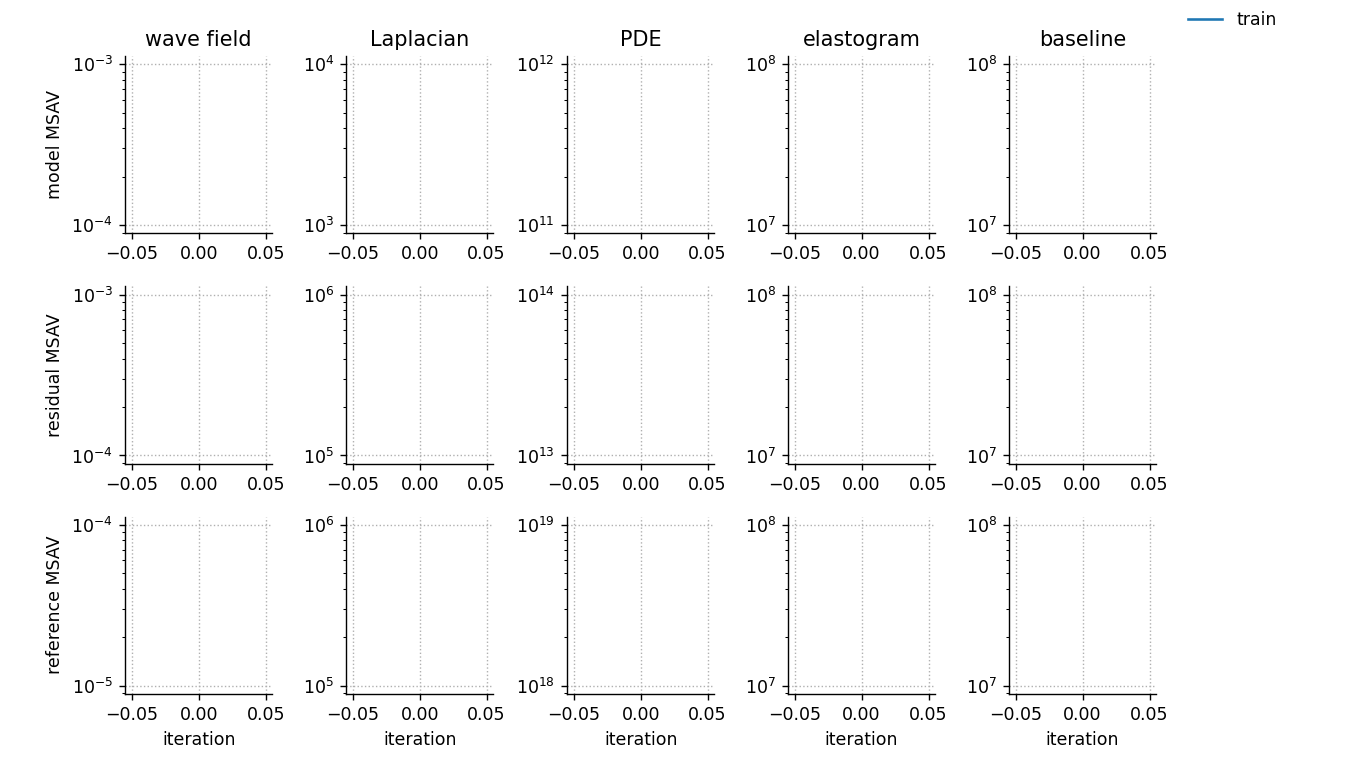

<IPython.core.display.Javascript object>


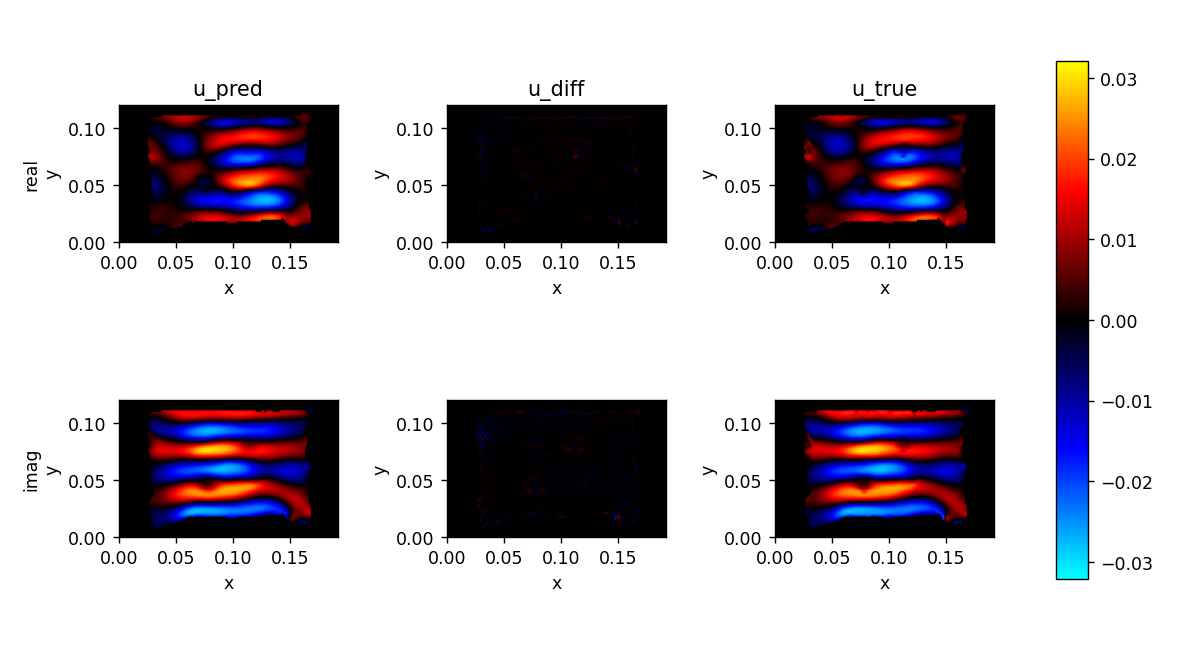

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


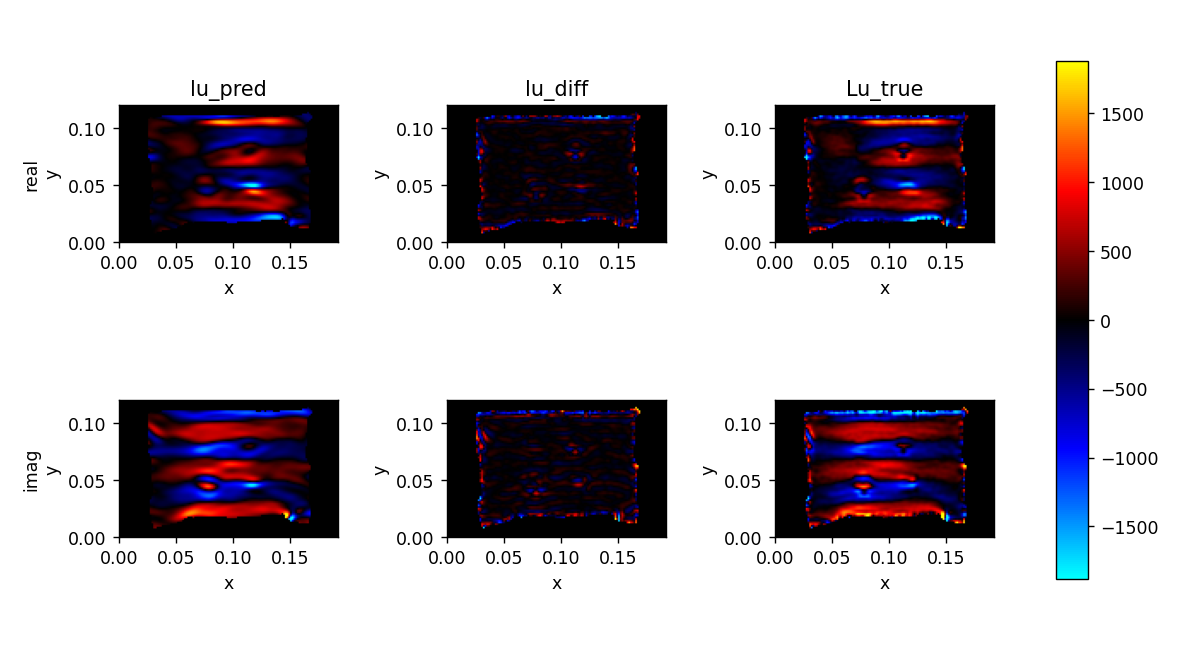

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


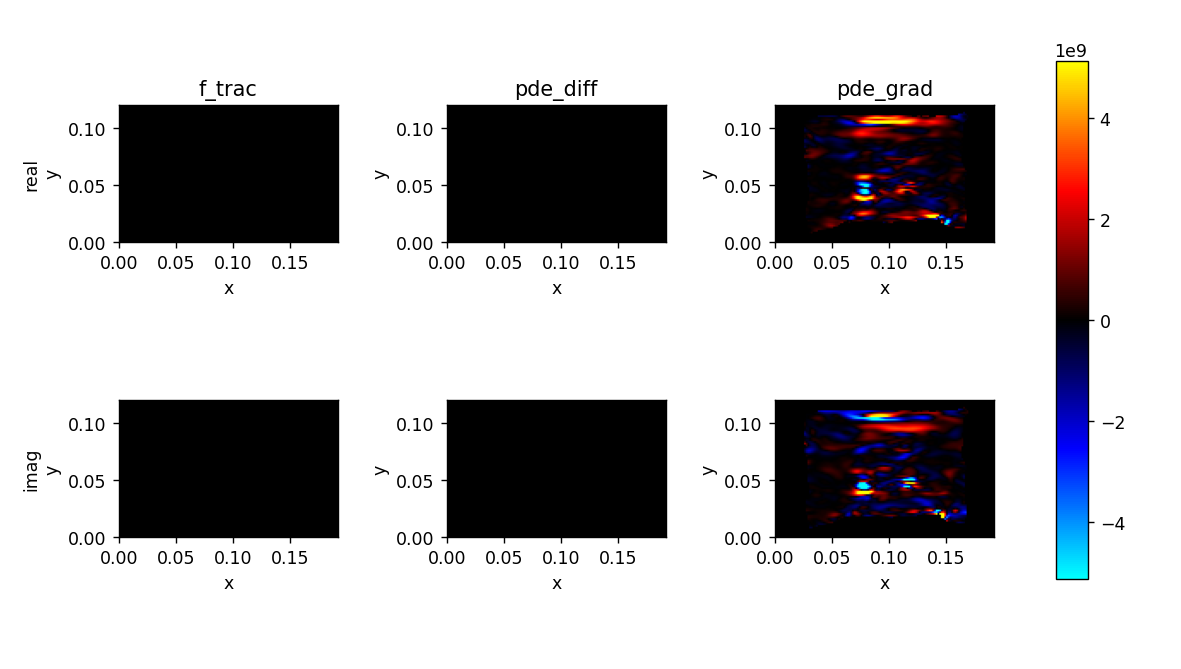

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


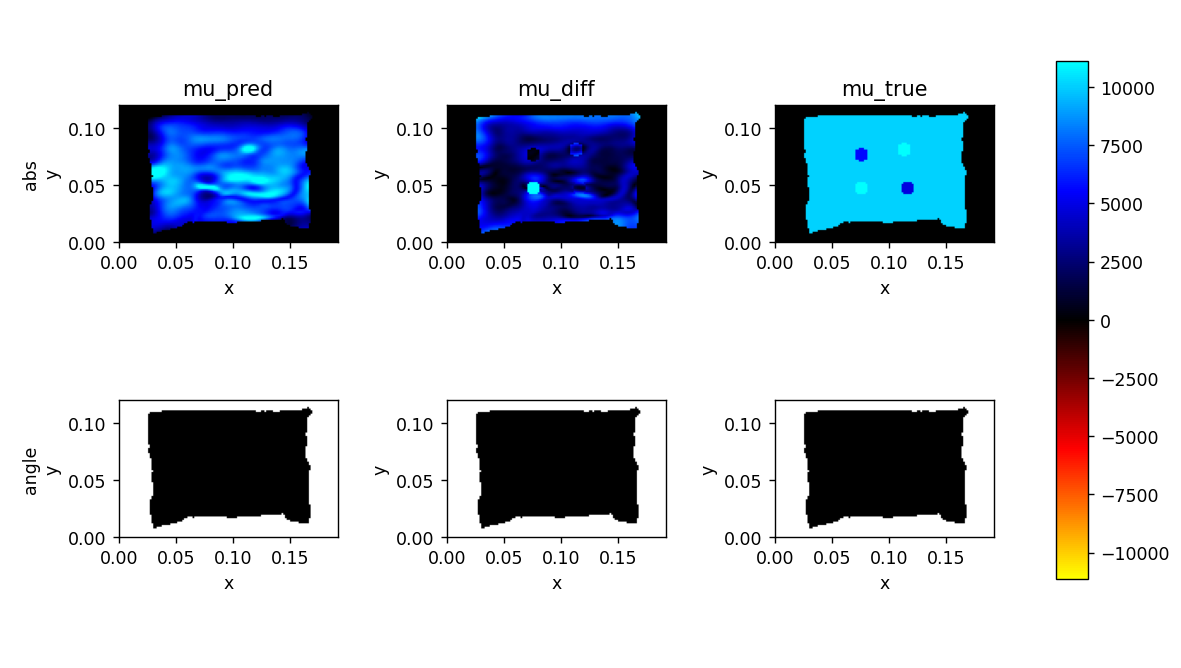

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


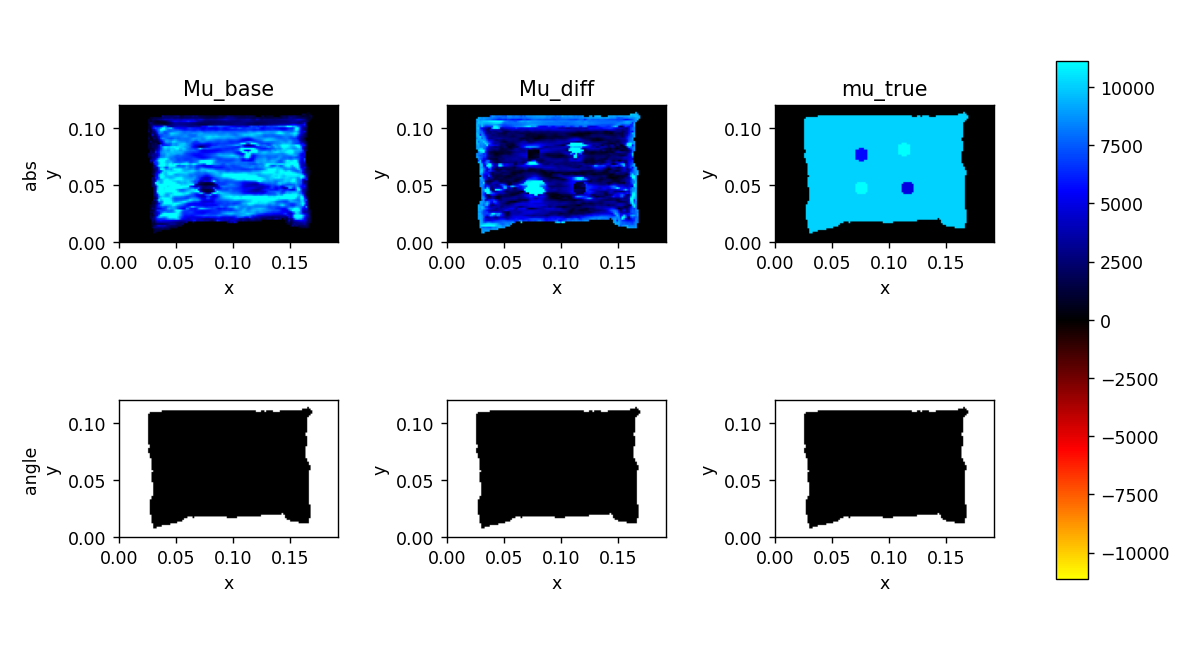

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [15]:
test_eval = mre_pinn.testing.TestEvaluator(test_every=100, interact=True)
test_eval.model = model
test_eval.test()

Training model...

0         [4.51e-04, 0.00e+00, 0.00e+00]    [4.41e-04, 0.00e+00, 0.00e+00]    []  


<IPython.core.display.Javascript object>


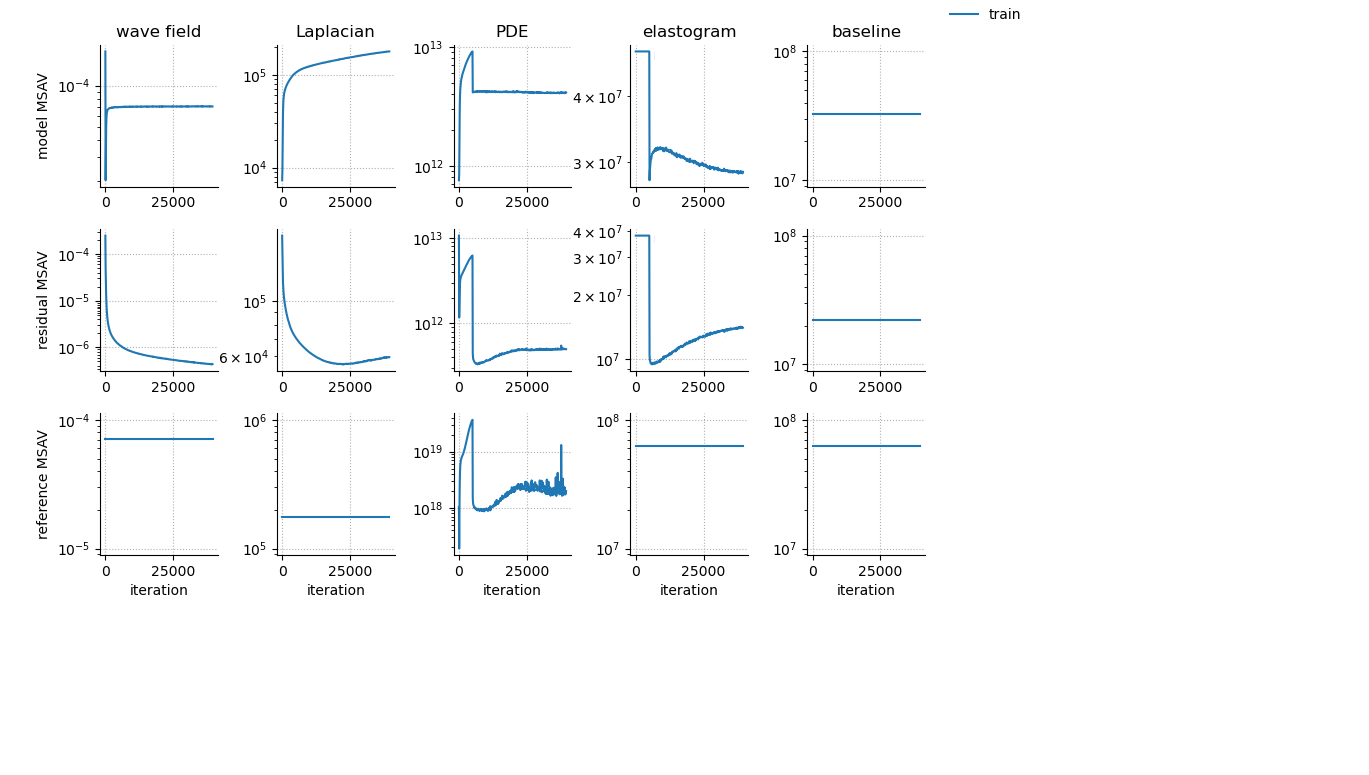

Time spent testing: 44.4261 (33.02%)
10        [2.91e-04, 0.00e+00, 0.00e+00]    [2.89e-04, 0.00e+00, 0.00e+00]    []  
20        [2.23e-04, 0.00e+00, 0.00e+00]    [2.13e-04, 0.00e+00, 0.00e+00]    []  
30        [1.73e-04, 0.00e+00, 0.00e+00]    [1.74e-04, 0.00e+00, 0.00e+00]    []  
40        [1.53e-04, 0.00e+00, 0.00e+00]    [1.48e-04, 0.00e+00, 0.00e+00]    []  
50        [1.36e-04, 0.00e+00, 0.00e+00]    [1.30e-04, 0.00e+00, 0.00e+00]    []  
60        [1.27e-04, 0.00e+00, 0.00e+00]    [1.17e-04, 0.00e+00, 0.00e+00]    []  
70        [1.10e-04, 0.00e+00, 0.00e+00]    [1.06e-04, 0.00e+00, 0.00e+00]    []  
80        [9.68e-05, 0.00e+00, 0.00e+00]    [9.72e-05, 0.00e+00, 0.00e+00]    []  
90        [9.39e-05, 0.00e+00, 0.00e+00]    [8.98e-05, 0.00e+00, 0.00e+00]    []  
100       [8.71e-05, 0.00e+00, 0.00e+00]    [8.31e-05, 0.00e+00, 0.00e+00]    []  
Time spent testing: 43.8653 (47.38%)
110       [8.01e-05, 0.00e+00, 0.00e+00]    [7.71e-05, 0.00e+00, 0.00e+00]    []  
120       [7.

960       [6.37e-06, 0.00e+00, 0.00e+00]    [6.26e-06, 0.00e+00, 0.00e+00]    []  
970       [6.04e-06, 0.00e+00, 0.00e+00]    [6.27e-06, 0.00e+00, 0.00e+00]    []  
980       [6.72e-06, 0.00e+00, 0.00e+00]    [6.24e-06, 0.00e+00, 0.00e+00]    []  
990       [6.20e-06, 0.00e+00, 0.00e+00]    [6.21e-06, 0.00e+00, 0.00e+00]    []  
1000      [5.17e-06, 0.00e+00, 0.00e+00]    [6.14e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 43.5531 (74.00%)
1010      [6.44e-06, 0.00e+00, 0.00e+00]    [6.08e-06, 0.00e+00, 0.00e+00]    []  
1020      [5.53e-06, 0.00e+00, 0.00e+00]    [6.05e-06, 0.00e+00, 0.00e+00]    []  
1030      [6.06e-06, 0.00e+00, 0.00e+00]    [6.00e-06, 0.00e+00, 0.00e+00]    []  
1040      [5.90e-06, 0.00e+00, 0.00e+00]    [5.94e-06, 0.00e+00, 0.00e+00]    []  
1050      [5.45e-06, 0.00e+00, 0.00e+00]    [5.92e-06, 0.00e+00, 0.00e+00]    []  
1060      [5.88e-06, 0.00e+00, 0.00e+00]    [5.89e-06, 0.00e+00, 0.00e+00]    []  
1070      [5.10e-06, 0.00e+00, 0.00e+00]    [5.87e

Time spent testing: 44.8822 (78.50%)
1910      [3.57e-06, 0.00e+00, 0.00e+00]    [3.95e-06, 0.00e+00, 0.00e+00]    []  
1920      [3.58e-06, 0.00e+00, 0.00e+00]    [3.93e-06, 0.00e+00, 0.00e+00]    []  
1930      [3.26e-06, 0.00e+00, 0.00e+00]    [3.96e-06, 0.00e+00, 0.00e+00]    []  
1940      [3.49e-06, 0.00e+00, 0.00e+00]    [3.93e-06, 0.00e+00, 0.00e+00]    []  
1950      [3.35e-06, 0.00e+00, 0.00e+00]    [3.93e-06, 0.00e+00, 0.00e+00]    []  
1960      [3.64e-06, 0.00e+00, 0.00e+00]    [3.93e-06, 0.00e+00, 0.00e+00]    []  
1970      [3.32e-06, 0.00e+00, 0.00e+00]    [3.92e-06, 0.00e+00, 0.00e+00]    []  
1980      [3.78e-06, 0.00e+00, 0.00e+00]    [3.92e-06, 0.00e+00, 0.00e+00]    []  
1990      [2.96e-06, 0.00e+00, 0.00e+00]    [3.91e-06, 0.00e+00, 0.00e+00]    []  
2000      [3.16e-06, 0.00e+00, 0.00e+00]    [3.87e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 45.3119 (78.70%)
2010      [3.47e-06, 0.00e+00, 0.00e+00]    [3.89e-06, 0.00e+00, 0.00e+00]    []  
2020      [3.

2860      [2.65e-06, 0.00e+00, 0.00e+00]    [3.13e-06, 0.00e+00, 0.00e+00]    []  
2870      [3.09e-06, 0.00e+00, 0.00e+00]    [3.14e-06, 0.00e+00, 0.00e+00]    []  
2880      [2.74e-06, 0.00e+00, 0.00e+00]    [3.12e-06, 0.00e+00, 0.00e+00]    []  
2890      [2.44e-06, 0.00e+00, 0.00e+00]    [3.18e-06, 0.00e+00, 0.00e+00]    []  
2900      [3.01e-06, 0.00e+00, 0.00e+00]    [3.16e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 45.9178 (80.26%)
2910      [2.71e-06, 0.00e+00, 0.00e+00]    [3.12e-06, 0.00e+00, 0.00e+00]    []  
2920      [2.48e-06, 0.00e+00, 0.00e+00]    [3.12e-06, 0.00e+00, 0.00e+00]    []  
2930      [2.84e-06, 0.00e+00, 0.00e+00]    [3.08e-06, 0.00e+00, 0.00e+00]    []  
2940      [2.93e-06, 0.00e+00, 0.00e+00]    [3.12e-06, 0.00e+00, 0.00e+00]    []  
2950      [2.87e-06, 0.00e+00, 0.00e+00]    [3.09e-06, 0.00e+00, 0.00e+00]    []  
2960      [3.11e-06, 0.00e+00, 0.00e+00]    [3.11e-06, 0.00e+00, 0.00e+00]    []  
2970      [2.68e-06, 0.00e+00, 0.00e+00]    [3.08e

Time spent testing: 46.0293 (81.07%)
3810      [2.07e-06, 0.00e+00, 0.00e+00]    [2.62e-06, 0.00e+00, 0.00e+00]    []  
3820      [2.51e-06, 0.00e+00, 0.00e+00]    [2.65e-06, 0.00e+00, 0.00e+00]    []  
3830      [2.55e-06, 0.00e+00, 0.00e+00]    [2.64e-06, 0.00e+00, 0.00e+00]    []  
3840      [2.48e-06, 0.00e+00, 0.00e+00]    [2.60e-06, 0.00e+00, 0.00e+00]    []  
3850      [2.12e-06, 0.00e+00, 0.00e+00]    [2.61e-06, 0.00e+00, 0.00e+00]    []  
3860      [2.24e-06, 0.00e+00, 0.00e+00]    [2.64e-06, 0.00e+00, 0.00e+00]    []  
3870      [2.16e-06, 0.00e+00, 0.00e+00]    [2.60e-06, 0.00e+00, 0.00e+00]    []  
3880      [2.17e-06, 0.00e+00, 0.00e+00]    [2.59e-06, 0.00e+00, 0.00e+00]    []  
3890      [2.54e-06, 0.00e+00, 0.00e+00]    [2.61e-06, 0.00e+00, 0.00e+00]    []  
3900      [1.99e-06, 0.00e+00, 0.00e+00]    [2.60e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 45.2276 (81.15%)
3910      [2.28e-06, 0.00e+00, 0.00e+00]    [2.58e-06, 0.00e+00, 0.00e+00]    []  
3920      [2.

4760      [1.87e-06, 0.00e+00, 0.00e+00]    [2.32e-06, 0.00e+00, 0.00e+00]    []  
4770      [1.97e-06, 0.00e+00, 0.00e+00]    [2.35e-06, 0.00e+00, 0.00e+00]    []  
4780      [1.93e-06, 0.00e+00, 0.00e+00]    [2.33e-06, 0.00e+00, 0.00e+00]    []  
4790      [2.05e-06, 0.00e+00, 0.00e+00]    [2.32e-06, 0.00e+00, 0.00e+00]    []  
4800      [1.91e-06, 0.00e+00, 0.00e+00]    [2.30e-06, 0.00e+00, 0.00e+00]    []  
Time spent testing: 46.3261 (81.70%)
4810      [1.84e-06, 0.00e+00, 0.00e+00]    [2.31e-06, 0.00e+00, 0.00e+00]    []  
4820      [2.03e-06, 0.00e+00, 0.00e+00]    [2.30e-06, 0.00e+00, 0.00e+00]    []  
4830      [1.73e-06, 0.00e+00, 0.00e+00]    [2.29e-06, 0.00e+00, 0.00e+00]    []  
4840      [1.92e-06, 0.00e+00, 0.00e+00]    [2.28e-06, 0.00e+00, 0.00e+00]    []  
4850      [2.59e-06, 0.00e+00, 0.00e+00]    [2.28e-06, 0.00e+00, 0.00e+00]    []  
4860      [1.98e-06, 0.00e+00, 0.00e+00]    [2.27e-06, 0.00e+00, 0.00e+00]    []  
4870      [2.22e-06, 0.00e+00, 0.00e+00]    [2.29e

Time spent testing: 46.7455 (82.11%)
5710      [1.80e-06, 0.00e+00, 6.66e-01]    [2.11e-06, 0.00e+00, 6.08e-01]    []  
5720      [1.93e-06, 0.00e+00, 5.87e-01]    [2.09e-06, 0.00e+00, 6.02e-01]    []  
5730      [1.59e-06, 0.00e+00, 6.29e-01]    [2.08e-06, 0.00e+00, 5.92e-01]    []  
5740      [1.82e-06, 0.00e+00, 5.81e-01]    [2.06e-06, 0.00e+00, 5.95e-01]    []  
5750      [1.81e-06, 0.00e+00, 6.43e-01]    [2.07e-06, 0.00e+00, 5.94e-01]    []  
5760      [2.05e-06, 0.00e+00, 6.17e-01]    [2.09e-06, 0.00e+00, 5.96e-01]    []  
5770      [1.80e-06, 0.00e+00, 6.56e-01]    [2.09e-06, 0.00e+00, 5.91e-01]    []  
5780      [1.77e-06, 0.00e+00, 5.93e-01]    [2.08e-06, 0.00e+00, 5.95e-01]    []  
5790      [1.58e-06, 0.00e+00, 6.10e-01]    [2.09e-06, 0.00e+00, 5.97e-01]    []  
5800      [2.12e-06, 0.00e+00, 6.47e-01]    [2.07e-06, 0.00e+00, 5.97e-01]    []  
Time spent testing: 47.7177 (82.12%)
5810      [1.69e-06, 0.00e+00, 6.62e-01]    [2.07e-06, 0.00e+00, 5.97e-01]    []  
5820      [1.

6660      [1.50e-06, 0.00e+00, 5.63e-01]    [1.91e-06, 0.00e+00, 5.83e-01]    []  
6670      [1.60e-06, 0.00e+00, 5.73e-01]    [1.91e-06, 0.00e+00, 5.85e-01]    []  
6680      [1.50e-06, 0.00e+00, 6.04e-01]    [1.89e-06, 0.00e+00, 5.91e-01]    []  
6690      [1.91e-06, 0.00e+00, 5.77e-01]    [1.90e-06, 0.00e+00, 5.82e-01]    []  
6700      [1.56e-06, 0.00e+00, 6.30e-01]    [1.87e-06, 0.00e+00, 5.82e-01]    []  
Time spent testing: 46.9312 (82.38%)
6710      [1.46e-06, 0.00e+00, 6.62e-01]    [1.89e-06, 0.00e+00, 5.82e-01]    []  
6720      [1.68e-06, 0.00e+00, 5.35e-01]    [1.89e-06, 0.00e+00, 5.82e-01]    []  
6730      [1.60e-06, 0.00e+00, 5.91e-01]    [1.89e-06, 0.00e+00, 5.91e-01]    []  
6740      [1.73e-06, 0.00e+00, 5.87e-01]    [1.89e-06, 0.00e+00, 5.79e-01]    []  
6750      [1.74e-06, 0.00e+00, 5.75e-01]    [1.90e-06, 0.00e+00, 5.83e-01]    []  
6760      [1.69e-06, 0.00e+00, 5.87e-01]    [1.89e-06, 0.00e+00, 5.86e-01]    []  
6770      [1.56e-06, 0.00e+00, 5.91e-01]    [1.86e

Time spent testing: 48.0862 (82.58%)
7610      [1.52e-06, 0.00e+00, 6.22e-01]    [1.74e-06, 0.00e+00, 5.90e-01]    []  
7620      [1.50e-06, 0.00e+00, 6.17e-01]    [1.75e-06, 0.00e+00, 5.87e-01]    []  
7630      [1.44e-06, 0.00e+00, 5.81e-01]    [1.77e-06, 0.00e+00, 5.86e-01]    []  
7640      [1.52e-06, 0.00e+00, 6.06e-01]    [1.75e-06, 0.00e+00, 5.83e-01]    []  
7650      [1.68e-06, 0.00e+00, 6.20e-01]    [1.74e-06, 0.00e+00, 5.87e-01]    []  
7660      [1.64e-06, 0.00e+00, 6.42e-01]    [1.75e-06, 0.00e+00, 6.01e-01]    []  
7670      [1.52e-06, 0.00e+00, 5.39e-01]    [1.75e-06, 0.00e+00, 5.97e-01]    []  
7680      [1.69e-06, 0.00e+00, 6.01e-01]    [1.74e-06, 0.00e+00, 6.00e-01]    []  
7690      [1.64e-06, 0.00e+00, 5.79e-01]    [1.78e-06, 0.00e+00, 6.04e-01]    []  
7700      [1.52e-06, 0.00e+00, 5.83e-01]    [1.76e-06, 0.00e+00, 6.03e-01]    []  
Time spent testing: 45.2739 (82.60%)
7710      [1.60e-06, 0.00e+00, 6.22e-01]    [1.75e-06, 0.00e+00, 6.02e-01]    []  
7720      [1.

8560      [1.79e-06, 0.00e+00, 5.85e-01]    [1.68e-06, 0.00e+00, 6.01e-01]    []  
8570      [1.36e-06, 0.00e+00, 6.06e-01]    [1.66e-06, 0.00e+00, 6.05e-01]    []  
8580      [1.40e-06, 0.00e+00, 5.79e-01]    [1.65e-06, 0.00e+00, 6.03e-01]    []  
8590      [1.59e-06, 0.00e+00, 5.96e-01]    [1.65e-06, 0.00e+00, 6.03e-01]    []  
8600      [1.55e-06, 0.00e+00, 5.80e-01]    [1.67e-06, 0.00e+00, 6.04e-01]    []  
Time spent testing: 45.2023 (82.74%)
8610      [1.59e-06, 0.00e+00, 6.27e-01]    [1.65e-06, 0.00e+00, 6.02e-01]    []  
8620      [1.78e-06, 0.00e+00, 5.81e-01]    [1.66e-06, 0.00e+00, 5.98e-01]    []  
8630      [1.43e-06, 0.00e+00, 5.62e-01]    [1.65e-06, 0.00e+00, 6.07e-01]    []  
8640      [1.50e-06, 0.00e+00, 6.13e-01]    [1.69e-06, 0.00e+00, 6.01e-01]    []  
8650      [1.40e-06, 0.00e+00, 6.54e-01]    [1.67e-06, 0.00e+00, 6.05e-01]    []  
8660      [1.53e-06, 0.00e+00, 6.29e-01]    [1.66e-06, 0.00e+00, 6.13e-01]    []  
8670      [1.74e-06, 0.00e+00, 6.23e-01]    [1.64e

Time spent testing: 45.7049 (82.82%)
9510      [1.60e-06, 0.00e+00, 6.55e-01]    [1.59e-06, 0.00e+00, 6.37e-01]    []  
9520      [1.46e-06, 0.00e+00, 7.09e-01]    [1.57e-06, 0.00e+00, 6.31e-01]    []  
9530      [1.21e-06, 0.00e+00, 6.54e-01]    [1.58e-06, 0.00e+00, 6.27e-01]    []  
9540      [1.56e-06, 0.00e+00, 6.34e-01]    [1.59e-06, 0.00e+00, 6.20e-01]    []  
9550      [1.44e-06, 0.00e+00, 6.46e-01]    [1.59e-06, 0.00e+00, 6.25e-01]    []  
9560      [1.22e-06, 0.00e+00, 6.27e-01]    [1.58e-06, 0.00e+00, 6.18e-01]    []  
9570      [1.69e-06, 0.00e+00, 7.24e-01]    [1.56e-06, 0.00e+00, 6.27e-01]    []  
9580      [1.28e-06, 0.00e+00, 6.29e-01]    [1.55e-06, 0.00e+00, 6.34e-01]    []  
9590      [1.38e-06, 0.00e+00, 6.09e-01]    [1.57e-06, 0.00e+00, 6.36e-01]    []  
9600      [1.28e-06, 0.00e+00, 6.15e-01]    [1.58e-06, 0.00e+00, 6.48e-01]    []  
Time spent testing: 44.8761 (82.82%)
9610      [1.42e-06, 0.00e+00, 5.81e-01]    [1.58e-06, 0.00e+00, 6.36e-01]    []  
9620      [1.

10460     [1.13e-06, 0.00e+00, 6.49e+00]    [1.50e-06, 0.00e+00, 6.38e+00]    []  
10470     [1.38e-06, 0.00e+00, 6.65e+00]    [1.50e-06, 0.00e+00, 6.37e+00]    []  
10480     [1.38e-06, 0.00e+00, 6.26e+00]    [1.52e-06, 0.00e+00, 6.46e+00]    []  
10490     [1.41e-06, 0.00e+00, 6.46e+00]    [1.54e-06, 0.00e+00, 6.50e+00]    []  
10500     [1.37e-06, 0.00e+00, 6.47e+00]    [1.51e-06, 0.00e+00, 6.61e+00]    []  
Time spent testing: 44.6534 (82.92%)
10510     [1.36e-06, 0.00e+00, 6.14e+00]    [1.52e-06, 0.00e+00, 6.58e+00]    []  
10520     [1.48e-06, 0.00e+00, 6.28e+00]    [1.50e-06, 0.00e+00, 6.41e+00]    []  
10530     [1.33e-06, 0.00e+00, 6.14e+00]    [1.53e-06, 0.00e+00, 6.37e+00]    []  
10540     [1.29e-06, 0.00e+00, 6.69e+00]    [1.53e-06, 0.00e+00, 6.50e+00]    []  
10550     [1.27e-06, 0.00e+00, 6.21e+00]    [1.52e-06, 0.00e+00, 6.56e+00]    []  
10560     [1.54e-06, 0.00e+00, 6.03e+00]    [1.53e-06, 0.00e+00, 6.35e+00]    []  
10570     [1.44e-06, 0.00e+00, 6.83e+00]    [1.54e

Time spent testing: 47.8924 (82.96%)
11410     [1.26e-06, 0.00e+00, 5.97e+00]    [1.45e-06, 0.00e+00, 6.66e+00]    []  
11420     [1.42e-06, 0.00e+00, 6.15e+00]    [1.47e-06, 0.00e+00, 6.89e+00]    []  
11430     [1.23e-06, 0.00e+00, 6.36e+00]    [1.46e-06, 0.00e+00, 6.85e+00]    []  
11440     [1.30e-06, 0.00e+00, 6.28e+00]    [1.44e-06, 0.00e+00, 6.75e+00]    []  
11450     [1.26e-06, 0.00e+00, 6.81e+00]    [1.45e-06, 0.00e+00, 6.85e+00]    []  
11460     [1.34e-06, 0.00e+00, 6.56e+00]    [1.47e-06, 0.00e+00, 6.78e+00]    []  
11470     [1.44e-06, 0.00e+00, 7.14e+00]    [1.47e-06, 0.00e+00, 6.77e+00]    []  
11480     [1.36e-06, 0.00e+00, 6.53e+00]    [1.45e-06, 0.00e+00, 6.94e+00]    []  
11490     [1.51e-06, 0.00e+00, 7.08e+00]    [1.43e-06, 0.00e+00, 6.78e+00]    []  
11500     [1.18e-06, 0.00e+00, 6.41e+00]    [1.44e-06, 0.00e+00, 6.86e+00]    []  
Time spent testing: 55.0526 (82.99%)
11510     [1.21e-06, 0.00e+00, 6.46e+00]    [1.45e-06, 0.00e+00, 6.76e+00]    []  
11520     [1.

12360     [1.45e-06, 0.00e+00, 6.17e+00]    [1.44e-06, 0.00e+00, 6.91e+00]    []  
12370     [1.36e-06, 0.00e+00, 6.84e+00]    [1.42e-06, 0.00e+00, 7.02e+00]    []  
12380     [1.07e-06, 0.00e+00, 6.27e+00]    [1.43e-06, 0.00e+00, 6.82e+00]    []  
12390     [1.23e-06, 0.00e+00, 6.71e+00]    [1.43e-06, 0.00e+00, 6.86e+00]    []  
12400     [1.22e-06, 0.00e+00, 7.89e+00]    [1.42e-06, 0.00e+00, 6.78e+00]    []  
Time spent testing: 45.3143 (83.06%)
12410     [1.20e-06, 0.00e+00, 7.31e+00]    [1.42e-06, 0.00e+00, 6.98e+00]    []  
12420     [1.41e-06, 0.00e+00, 7.38e+00]    [1.42e-06, 0.00e+00, 6.93e+00]    []  
12430     [1.51e-06, 0.00e+00, 7.97e+00]    [1.41e-06, 0.00e+00, 6.79e+00]    []  
12440     [1.44e-06, 0.00e+00, 6.98e+00]    [1.42e-06, 0.00e+00, 6.79e+00]    []  
12450     [1.41e-06, 0.00e+00, 6.59e+00]    [1.41e-06, 0.00e+00, 6.72e+00]    []  
12460     [1.23e-06, 0.00e+00, 7.21e+00]    [1.43e-06, 0.00e+00, 6.83e+00]    []  
12470     [1.45e-06, 0.00e+00, 7.46e+00]    [1.40e

Time spent testing: 44.5713 (83.14%)
13310     [1.27e-06, 0.00e+00, 7.13e+00]    [1.35e-06, 0.00e+00, 6.96e+00]    []  
13320     [1.41e-06, 0.00e+00, 7.00e+00]    [1.39e-06, 0.00e+00, 6.93e+00]    []  
13330     [1.33e-06, 0.00e+00, 6.48e+00]    [1.39e-06, 0.00e+00, 6.92e+00]    []  
13340     [1.27e-06, 0.00e+00, 6.90e+00]    [1.37e-06, 0.00e+00, 6.82e+00]    []  
13350     [1.16e-06, 0.00e+00, 6.49e+00]    [1.36e-06, 0.00e+00, 6.91e+00]    []  
13360     [1.22e-06, 0.00e+00, 7.23e+00]    [1.36e-06, 0.00e+00, 6.96e+00]    []  
13370     [1.11e-06, 0.00e+00, 7.45e+00]    [1.37e-06, 0.00e+00, 6.98e+00]    []  
13380     [1.09e-06, 0.00e+00, 6.78e+00]    [1.37e-06, 0.00e+00, 6.88e+00]    []  
13390     [1.28e-06, 0.00e+00, 6.70e+00]    [1.35e-06, 0.00e+00, 6.89e+00]    []  
13400     [1.25e-06, 0.00e+00, 6.67e+00]    [1.36e-06, 0.00e+00, 7.04e+00]    []  
Time spent testing: 46.0375 (83.14%)
13410     [1.44e-06, 0.00e+00, 7.18e+00]    [1.34e-06, 0.00e+00, 7.00e+00]    []  
13420     [1.

14260     [1.24e-06, 0.00e+00, 6.71e+00]    [1.34e-06, 0.00e+00, 7.16e+00]    []  
14270     [1.29e-06, 0.00e+00, 8.00e+00]    [1.33e-06, 0.00e+00, 6.99e+00]    []  
14280     [1.19e-06, 0.00e+00, 7.01e+00]    [1.31e-06, 0.00e+00, 7.02e+00]    []  
14290     [1.42e-06, 0.00e+00, 7.80e+00]    [1.30e-06, 0.00e+00, 7.14e+00]    []  
14300     [1.43e-06, 0.00e+00, 7.65e+00]    [1.30e-06, 0.00e+00, 7.13e+00]    []  
Time spent testing: 45.8703 (83.21%)
14310     [1.12e-06, 0.00e+00, 6.99e+00]    [1.31e-06, 0.00e+00, 7.07e+00]    []  
14320     [1.29e-06, 0.00e+00, 7.35e+00]    [1.32e-06, 0.00e+00, 7.07e+00]    []  
14330     [1.08e-06, 0.00e+00, 7.47e+00]    [1.32e-06, 0.00e+00, 7.05e+00]    []  
14340     [1.39e-06, 0.00e+00, 6.73e+00]    [1.33e-06, 0.00e+00, 7.11e+00]    []  
14350     [1.13e-06, 0.00e+00, 7.38e+00]    [1.34e-06, 0.00e+00, 7.02e+00]    []  
14360     [1.24e-06, 0.00e+00, 7.48e+00]    [1.32e-06, 0.00e+00, 7.06e+00]    []  
14370     [1.26e-06, 0.00e+00, 7.17e+00]    [1.32e

Time spent testing: 46.5632 (83.28%)
15210     [1.17e-06, 0.00e+00, 7.90e+01]    [1.30e-06, 0.00e+00, 7.50e+01]    []  
15220     [9.66e-07, 0.00e+00, 7.46e+01]    [1.29e-06, 0.00e+00, 7.62e+01]    []  
15230     [1.39e-06, 0.00e+00, 7.02e+01]    [1.29e-06, 0.00e+00, 7.47e+01]    []  
15240     [1.03e-06, 0.00e+00, 8.16e+01]    [1.32e-06, 0.00e+00, 7.50e+01]    []  
15250     [1.18e-06, 0.00e+00, 6.79e+01]    [1.28e-06, 0.00e+00, 7.55e+01]    []  
15260     [1.18e-06, 0.00e+00, 7.27e+01]    [1.30e-06, 0.00e+00, 7.36e+01]    []  
15270     [1.38e-06, 0.00e+00, 8.66e+01]    [1.29e-06, 0.00e+00, 7.43e+01]    []  
15280     [1.09e-06, 0.00e+00, 7.27e+01]    [1.30e-06, 0.00e+00, 7.59e+01]    []  
15290     [1.26e-06, 0.00e+00, 7.49e+01]    [1.30e-06, 0.00e+00, 7.62e+01]    []  
15300     [1.12e-06, 0.00e+00, 6.68e+01]    [1.30e-06, 0.00e+00, 7.43e+01]    []  
Time spent testing: 48.0815 (83.30%)
15310     [1.51e-06, 0.00e+00, 8.78e+01]    [1.29e-06, 0.00e+00, 7.52e+01]    []  
15320     [1.

16160     [1.20e-06, 0.00e+00, 6.90e+01]    [1.25e-06, 0.00e+00, 7.64e+01]    []  
16170     [9.65e-07, 0.00e+00, 7.67e+01]    [1.24e-06, 0.00e+00, 7.63e+01]    []  
16180     [1.04e-06, 0.00e+00, 7.72e+01]    [1.24e-06, 0.00e+00, 7.46e+01]    []  
16190     [1.38e-06, 0.00e+00, 7.42e+01]    [1.25e-06, 0.00e+00, 7.45e+01]    []  
16200     [1.14e-06, 0.00e+00, 8.93e+01]    [1.25e-06, 0.00e+00, 7.60e+01]    []  
Time spent testing: 45.3970 (83.34%)
16210     [1.20e-06, 0.00e+00, 7.61e+01]    [1.25e-06, 0.00e+00, 7.69e+01]    []  
16220     [1.07e-06, 0.00e+00, 8.41e+01]    [1.26e-06, 0.00e+00, 7.65e+01]    []  
16230     [1.08e-06, 0.00e+00, 7.35e+01]    [1.26e-06, 0.00e+00, 7.61e+01]    []  
16240     [1.03e-06, 0.00e+00, 7.03e+01]    [1.25e-06, 0.00e+00, 7.61e+01]    []  
16250     [1.25e-06, 0.00e+00, 7.39e+01]    [1.25e-06, 0.00e+00, 7.66e+01]    []  
16260     [1.17e-06, 0.00e+00, 7.73e+01]    [1.27e-06, 0.00e+00, 7.80e+01]    []  
16270     [1.07e-06, 0.00e+00, 7.38e+01]    [1.25e

Time spent testing: 44.6824 (83.38%)
17110     [1.00e-06, 0.00e+00, 7.04e+01]    [1.21e-06, 0.00e+00, 7.80e+01]    []  
17120     [1.15e-06, 0.00e+00, 7.47e+01]    [1.20e-06, 0.00e+00, 7.61e+01]    []  
17130     [1.28e-06, 0.00e+00, 7.15e+01]    [1.20e-06, 0.00e+00, 7.69e+01]    []  
17140     [9.83e-07, 0.00e+00, 7.87e+01]    [1.22e-06, 0.00e+00, 7.78e+01]    []  
17150     [9.97e-07, 0.00e+00, 8.82e+01]    [1.22e-06, 0.00e+00, 7.64e+01]    []  
17160     [8.61e-07, 0.00e+00, 9.10e+01]    [1.22e-06, 0.00e+00, 7.72e+01]    []  
17170     [1.13e-06, 0.00e+00, 7.99e+01]    [1.24e-06, 0.00e+00, 7.66e+01]    []  
17180     [1.08e-06, 0.00e+00, 8.47e+01]    [1.24e-06, 0.00e+00, 7.76e+01]    []  
17190     [1.19e-06, 0.00e+00, 8.16e+01]    [1.24e-06, 0.00e+00, 7.73e+01]    []  
17200     [9.42e-07, 0.00e+00, 8.35e+01]    [1.23e-06, 0.00e+00, 7.63e+01]    []  
Time spent testing: 45.5029 (83.37%)
17210     [1.14e-06, 0.00e+00, 7.11e+01]    [1.24e-06, 0.00e+00, 7.67e+01]    []  
17220     [1.

18060     [1.01e-06, 0.00e+00, 8.64e+01]    [1.17e-06, 0.00e+00, 8.19e+01]    []  
18070     [1.02e-06, 0.00e+00, 8.54e+01]    [1.17e-06, 0.00e+00, 8.19e+01]    []  
18080     [1.11e-06, 0.00e+00, 7.55e+01]    [1.16e-06, 0.00e+00, 8.04e+01]    []  
18090     [1.07e-06, 0.00e+00, 8.13e+01]    [1.18e-06, 0.00e+00, 8.04e+01]    []  
18100     [9.79e-07, 0.00e+00, 7.50e+01]    [1.17e-06, 0.00e+00, 8.24e+01]    []  
Time spent testing: 44.9059 (83.43%)
18110     [1.22e-06, 0.00e+00, 7.29e+01]    [1.19e-06, 0.00e+00, 8.11e+01]    []  
18120     [1.41e-06, 0.00e+00, 7.43e+01]    [1.20e-06, 0.00e+00, 8.37e+01]    []  
18130     [1.04e-06, 0.00e+00, 7.67e+01]    [1.18e-06, 0.00e+00, 8.04e+01]    []  
18140     [1.01e-06, 0.00e+00, 8.42e+01]    [1.16e-06, 0.00e+00, 8.07e+01]    []  
18150     [9.78e-07, 0.00e+00, 7.84e+01]    [1.17e-06, 0.00e+00, 7.97e+01]    []  
18160     [1.15e-06, 0.00e+00, 8.36e+01]    [1.16e-06, 0.00e+00, 7.95e+01]    []  
18170     [1.06e-06, 0.00e+00, 8.40e+01]    [1.18e

Time spent testing: 46.1529 (83.47%)
19010     [1.16e-06, 0.00e+00, 9.68e+01]    [1.17e-06, 0.00e+00, 9.02e+01]    []  
19020     [1.04e-06, 0.00e+00, 8.77e+01]    [1.17e-06, 0.00e+00, 8.16e+01]    []  
19030     [1.20e-06, 0.00e+00, 7.79e+01]    [1.17e-06, 0.00e+00, 8.30e+01]    []  
19040     [1.07e-06, 0.00e+00, 8.21e+01]    [1.16e-06, 0.00e+00, 8.59e+01]    []  
19050     [1.19e-06, 0.00e+00, 8.09e+01]    [1.18e-06, 0.00e+00, 8.38e+01]    []  
19060     [1.23e-06, 0.00e+00, 8.99e+01]    [1.18e-06, 0.00e+00, 8.50e+01]    []  
19070     [1.18e-06, 0.00e+00, 7.97e+01]    [1.17e-06, 0.00e+00, 8.25e+01]    []  
19080     [9.58e-07, 0.00e+00, 8.10e+01]    [1.17e-06, 0.00e+00, 8.29e+01]    []  
19090     [1.18e-06, 0.00e+00, 7.35e+01]    [1.15e-06, 0.00e+00, 8.43e+01]    []  
19100     [1.21e-06, 0.00e+00, 8.63e+01]    [1.16e-06, 0.00e+00, 8.38e+01]    []  
Time spent testing: 44.7507 (83.47%)
19110     [1.05e-06, 0.00e+00, 8.35e+01]    [1.17e-06, 0.00e+00, 8.19e+01]    []  
19120     [9.

19960     [1.07e-06, 0.00e+00, 7.70e+01]    [1.14e-06, 0.00e+00, 8.32e+01]    []  
19970     [9.72e-07, 0.00e+00, 7.71e+01]    [1.13e-06, 0.00e+00, 8.82e+01]    []  
19980     [1.03e-06, 0.00e+00, 8.82e+01]    [1.14e-06, 0.00e+00, 8.55e+01]    []  
19990     [9.47e-07, 0.00e+00, 7.89e+01]    [1.14e-06, 0.00e+00, 8.47e+01]    []  
20000     [1.27e-06, 0.00e+00, 8.47e+01]    [1.11e-06, 0.00e+00, 8.43e+01]    []  
Time spent testing: 45.2400 (83.51%)
20010     [1.08e-06, 0.00e+00, 8.26e+01]    [1.13e-06, 0.00e+00, 8.73e+01]    []  
20020     [8.29e-07, 0.00e+00, 7.20e+01]    [1.14e-06, 0.00e+00, 8.41e+01]    []  
20030     [1.30e-06, 0.00e+00, 8.04e+01]    [1.14e-06, 0.00e+00, 8.37e+01]    []  
20040     [9.34e-07, 0.00e+00, 8.32e+01]    [1.15e-06, 0.00e+00, 8.45e+01]    []  
20050     [1.22e-06, 0.00e+00, 8.19e+01]    [1.14e-06, 0.00e+00, 8.53e+01]    []  
20060     [1.11e-06, 0.00e+00, 8.05e+01]    [1.16e-06, 0.00e+00, 8.42e+01]    []  
20070     [9.38e-07, 0.00e+00, 7.80e+01]    [1.14e

Time spent testing: 43.7180 (83.54%)
20910     [9.11e-07, 0.00e+00, 8.28e+01]    [1.09e-06, 0.00e+00, 8.45e+01]    []  
20920     [1.02e-06, 0.00e+00, 8.57e+01]    [1.10e-06, 0.00e+00, 8.37e+01]    []  
20930     [1.03e-06, 0.00e+00, 8.19e+01]    [1.11e-06, 0.00e+00, 8.33e+01]    []  
20940     [1.01e-06, 0.00e+00, 7.88e+01]    [1.10e-06, 0.00e+00, 8.46e+01]    []  
20950     [1.05e-06, 0.00e+00, 7.68e+01]    [1.11e-06, 0.00e+00, 8.57e+01]    []  
20960     [1.07e-06, 0.00e+00, 8.24e+01]    [1.10e-06, 0.00e+00, 8.36e+01]    []  
20970     [8.75e-07, 0.00e+00, 7.95e+01]    [1.10e-06, 0.00e+00, 8.41e+01]    []  
20980     [1.03e-06, 0.00e+00, 8.09e+01]    [1.10e-06, 0.00e+00, 8.50e+01]    []  
20990     [8.73e-07, 0.00e+00, 8.20e+01]    [1.10e-06, 0.00e+00, 8.51e+01]    []  
21000     [1.10e-06, 0.00e+00, 8.01e+01]    [1.09e-06, 0.00e+00, 9.24e+01]    []  
Time spent testing: 43.6535 (83.55%)
21010     [9.43e-07, 0.00e+00, 8.51e+01]    [1.09e-06, 0.00e+00, 9.45e+01]    []  
21020     [9.

21860     [9.95e-07, 0.00e+00, 9.33e+01]    [1.11e-06, 0.00e+00, 8.70e+01]    []  
21870     [1.22e-06, 0.00e+00, 8.35e+01]    [1.09e-06, 0.00e+00, 8.70e+01]    []  
21880     [9.98e-07, 0.00e+00, 8.31e+01]    [1.10e-06, 0.00e+00, 8.76e+01]    []  
21890     [9.74e-07, 0.00e+00, 8.43e+01]    [1.09e-06, 0.00e+00, 8.79e+01]    []  
21900     [1.08e-06, 0.00e+00, 8.74e+01]    [1.10e-06, 0.00e+00, 9.11e+01]    []  
Time spent testing: 44.2567 (83.57%)
21910     [9.82e-07, 0.00e+00, 9.49e+01]    [1.09e-06, 0.00e+00, 8.72e+01]    []  
21920     [1.13e-06, 0.00e+00, 8.01e+01]    [1.10e-06, 0.00e+00, 8.57e+01]    []  
21930     [8.26e-07, 0.00e+00, 9.01e+01]    [1.09e-06, 0.00e+00, 9.42e+01]    []  
21940     [9.56e-07, 0.00e+00, 7.75e+01]    [1.09e-06, 0.00e+00, 8.54e+01]    []  
21950     [1.08e-06, 0.00e+00, 8.31e+01]    [1.11e-06, 0.00e+00, 8.82e+01]    []  
21960     [1.05e-06, 0.00e+00, 9.27e+01]    [1.12e-06, 0.00e+00, 8.96e+01]    []  
21970     [1.00e-06, 0.00e+00, 9.60e+01]    [1.12e

Time spent testing: 44.1078 (83.62%)
22810     [9.23e-07, 0.00e+00, 8.78e+01]    [1.10e-06, 0.00e+00, 8.83e+01]    []  
22820     [1.01e-06, 0.00e+00, 8.34e+01]    [1.09e-06, 0.00e+00, 8.69e+01]    []  
22830     [1.11e-06, 0.00e+00, 8.33e+01]    [1.08e-06, 0.00e+00, 9.54e+01]    []  
22840     [9.10e-07, 0.00e+00, 8.36e+01]    [1.06e-06, 0.00e+00, 9.14e+01]    []  
22850     [9.87e-07, 0.00e+00, 9.99e+01]    [1.08e-06, 0.00e+00, 8.56e+01]    []  
22860     [8.59e-07, 0.00e+00, 9.84e+01]    [1.07e-06, 0.00e+00, 8.75e+01]    []  
22870     [8.88e-07, 0.00e+00, 8.48e+01]    [1.07e-06, 0.00e+00, 8.92e+01]    []  
22880     [1.23e-06, 0.00e+00, 8.31e+01]    [1.07e-06, 0.00e+00, 8.64e+01]    []  
22890     [1.13e-06, 0.00e+00, 9.45e+01]    [1.07e-06, 0.00e+00, 8.50e+01]    []  
22900     [7.39e-07, 0.00e+00, 8.19e+01]    [1.07e-06, 0.00e+00, 8.66e+01]    []  
Time spent testing: 45.2829 (83.63%)
22910     [9.95e-07, 0.00e+00, 9.21e+01]    [1.08e-06, 0.00e+00, 8.92e+01]    []  
22920     [1.

23760     [1.12e-06, 0.00e+00, 9.53e+01]    [1.07e-06, 0.00e+00, 8.51e+01]    []  
23770     [8.46e-07, 0.00e+00, 8.75e+01]    [1.08e-06, 0.00e+00, 8.63e+01]    []  
23780     [9.84e-07, 0.00e+00, 8.17e+01]    [1.09e-06, 0.00e+00, 8.81e+01]    []  
23790     [7.90e-07, 0.00e+00, 8.11e+01]    [1.08e-06, 0.00e+00, 8.57e+01]    []  
23800     [8.51e-07, 0.00e+00, 8.41e+01]    [1.07e-06, 0.00e+00, 8.56e+01]    []  
Time spent testing: 47.7183 (83.66%)
23810     [9.00e-07, 0.00e+00, 8.38e+01]    [1.08e-06, 0.00e+00, 8.54e+01]    []  
23820     [8.95e-07, 0.00e+00, 9.91e+01]    [1.08e-06, 0.00e+00, 8.47e+01]    []  
23830     [1.08e-06, 0.00e+00, 7.90e+01]    [1.07e-06, 0.00e+00, 8.46e+01]    []  
23840     [9.87e-07, 0.00e+00, 8.71e+01]    [1.08e-06, 0.00e+00, 8.54e+01]    []  
23850     [8.71e-07, 0.00e+00, 8.38e+01]    [1.08e-06, 0.00e+00, 8.63e+01]    []  
23860     [1.15e-06, 0.00e+00, 8.60e+01]    [1.07e-06, 0.00e+00, 8.37e+01]    []  
23870     [9.45e-07, 0.00e+00, 8.86e+01]    [1.06e

Time spent testing: 46.3923 (83.68%)
24710     [1.10e-06, 0.00e+00, 9.17e+01]    [1.05e-06, 0.00e+00, 8.50e+01]    []  
24720     [7.32e-07, 0.00e+00, 9.27e+01]    [1.06e-06, 0.00e+00, 8.50e+01]    []  
24730     [9.05e-07, 0.00e+00, 9.76e+01]    [1.04e-06, 0.00e+00, 8.38e+01]    []  
24740     [8.49e-07, 0.00e+00, 7.77e+01]    [1.07e-06, 0.00e+00, 8.65e+01]    []  
24750     [1.05e-06, 0.00e+00, 7.44e+01]    [1.06e-06, 0.00e+00, 8.43e+01]    []  
24760     [1.10e-06, 0.00e+00, 8.12e+01]    [1.05e-06, 0.00e+00, 8.54e+01]    []  
24770     [1.03e-06, 0.00e+00, 8.40e+01]    [1.04e-06, 0.00e+00, 8.42e+01]    []  
24780     [1.04e-06, 0.00e+00, 8.44e+01]    [1.05e-06, 0.00e+00, 8.39e+01]    []  
24790     [8.56e-07, 0.00e+00, 8.80e+01]    [1.07e-06, 0.00e+00, 8.72e+01]    []  
24800     [8.34e-07, 0.00e+00, 1.03e+02]    [1.05e-06, 0.00e+00, 9.17e+01]    []  
Time spent testing: 47.1180 (83.69%)
24810     [6.78e-07, 0.00e+00, 9.17e+01]    [1.05e-06, 0.00e+00, 8.52e+01]    []  
24820     [8.

25660     [9.00e-07, 0.00e+00, 8.42e+01]    [1.02e-06, 0.00e+00, 8.45e+01]    []  
25670     [8.66e-07, 0.00e+00, 8.29e+01]    [1.00e-06, 0.00e+00, 8.58e+01]    []  
25680     [8.73e-07, 0.00e+00, 8.28e+01]    [1.01e-06, 0.00e+00, 8.45e+01]    []  
25690     [9.09e-07, 0.00e+00, 9.26e+01]    [1.02e-06, 0.00e+00, 8.56e+01]    []  
25700     [8.90e-07, 0.00e+00, 9.09e+01]    [1.02e-06, 0.00e+00, 8.42e+01]    []  
Time spent testing: 48.1435 (83.70%)
25710     [1.02e-06, 0.00e+00, 7.92e+01]    [1.02e-06, 0.00e+00, 8.33e+01]    []  
25720     [1.05e-06, 0.00e+00, 9.37e+01]    [1.02e-06, 0.00e+00, 8.24e+01]    []  
25730     [8.19e-07, 0.00e+00, 8.15e+01]    [1.02e-06, 0.00e+00, 8.31e+01]    []  
25740     [9.76e-07, 0.00e+00, 8.83e+01]    [9.90e-07, 0.00e+00, 8.31e+01]    []  
25750     [8.77e-07, 0.00e+00, 8.36e+01]    [9.96e-07, 0.00e+00, 8.46e+01]    []  
25760     [7.83e-07, 0.00e+00, 8.12e+01]    [9.99e-07, 0.00e+00, 8.38e+01]    []  
25770     [8.49e-07, 0.00e+00, 8.43e+01]    [9.97e

Time spent testing: 50.4696 (83.74%)
26610     [8.20e-07, 0.00e+00, 7.82e+01]    [1.00e-06, 0.00e+00, 8.67e+01]    []  
26620     [8.98e-07, 0.00e+00, 8.15e+01]    [9.97e-07, 0.00e+00, 8.71e+01]    []  
26630     [8.52e-07, 0.00e+00, 8.72e+01]    [1.00e-06, 0.00e+00, 8.69e+01]    []  
26640     [7.48e-07, 0.00e+00, 8.22e+01]    [9.98e-07, 0.00e+00, 8.79e+01]    []  
26650     [1.03e-06, 0.00e+00, 8.14e+01]    [1.00e-06, 0.00e+00, 8.65e+01]    []  
26660     [7.83e-07, 0.00e+00, 8.30e+01]    [1.01e-06, 0.00e+00, 8.58e+01]    []  
26670     [9.19e-07, 0.00e+00, 8.75e+01]    [1.00e-06, 0.00e+00, 8.53e+01]    []  
26680     [9.59e-07, 0.00e+00, 8.28e+01]    [1.01e-06, 0.00e+00, 8.40e+01]    []  
26690     [8.08e-07, 0.00e+00, 8.06e+01]    [1.01e-06, 0.00e+00, 8.51e+01]    []  
26700     [8.58e-07, 0.00e+00, 1.01e+02]    [9.92e-07, 0.00e+00, 8.46e+01]    []  
Time spent testing: 50.0149 (83.75%)
26710     [8.92e-07, 0.00e+00, 7.77e+01]    [1.00e-06, 0.00e+00, 8.42e+01]    []  
26720     [7.

27560     [8.12e-07, 0.00e+00, 9.59e+01]    [1.00e-06, 0.00e+00, 8.56e+01]    []  
27570     [8.62e-07, 0.00e+00, 8.25e+01]    [9.97e-07, 0.00e+00, 8.59e+01]    []  
27580     [8.27e-07, 0.00e+00, 8.90e+01]    [1.00e-06, 0.00e+00, 8.58e+01]    []  
27590     [1.06e-06, 0.00e+00, 8.05e+01]    [1.01e-06, 0.00e+00, 8.53e+01]    []  
27600     [8.94e-07, 0.00e+00, 9.61e+01]    [9.92e-07, 0.00e+00, 8.47e+01]    []  
Time spent testing: 49.0935 (83.77%)
27610     [8.80e-07, 0.00e+00, 9.12e+01]    [9.94e-07, 0.00e+00, 8.50e+01]    []  
27620     [9.74e-07, 0.00e+00, 8.18e+01]    [9.83e-07, 0.00e+00, 8.60e+01]    []  
27630     [7.66e-07, 0.00e+00, 8.44e+01]    [9.85e-07, 0.00e+00, 8.59e+01]    []  
27640     [8.21e-07, 0.00e+00, 8.72e+01]    [9.96e-07, 0.00e+00, 8.52e+01]    []  
27650     [8.38e-07, 0.00e+00, 7.91e+01]    [9.73e-07, 0.00e+00, 8.44e+01]    []  
27660     [9.78e-07, 0.00e+00, 8.55e+01]    [9.92e-07, 0.00e+00, 8.51e+01]    []  
27670     [6.99e-07, 0.00e+00, 8.83e+01]    [9.89e

Time spent testing: 49.2043 (83.78%)
28510     [9.13e-07, 0.00e+00, 8.98e+01]    [9.80e-07, 0.00e+00, 8.41e+01]    []  
28520     [7.00e-07, 0.00e+00, 8.77e+01]    [9.72e-07, 0.00e+00, 8.52e+01]    []  
28530     [8.07e-07, 0.00e+00, 8.84e+01]    [9.78e-07, 0.00e+00, 8.49e+01]    []  
28540     [1.01e-06, 0.00e+00, 8.63e+01]    [9.85e-07, 0.00e+00, 8.59e+01]    []  
28550     [7.44e-07, 0.00e+00, 8.75e+01]    [9.75e-07, 0.00e+00, 8.57e+01]    []  
28560     [9.05e-07, 0.00e+00, 9.07e+01]    [9.77e-07, 0.00e+00, 8.54e+01]    []  
28570     [9.08e-07, 0.00e+00, 8.41e+01]    [9.90e-07, 0.00e+00, 8.43e+01]    []  
28580     [9.14e-07, 0.00e+00, 7.47e+01]    [9.94e-07, 0.00e+00, 8.48e+01]    []  
28590     [8.11e-07, 0.00e+00, 8.27e+01]    [9.97e-07, 0.00e+00, 8.55e+01]    []  
28600     [7.34e-07, 0.00e+00, 8.69e+01]    [9.92e-07, 0.00e+00, 8.57e+01]    []  
Time spent testing: 48.5572 (83.78%)
28610     [9.38e-07, 0.00e+00, 1.04e+02]    [9.82e-07, 0.00e+00, 8.45e+01]    []  
28620     [7.

29460     [8.74e-07, 0.00e+00, 8.94e+01]    [9.63e-07, 0.00e+00, 8.60e+01]    []  
29470     [8.88e-07, 0.00e+00, 8.61e+01]    [9.56e-07, 0.00e+00, 8.88e+01]    []  
29480     [1.03e-06, 0.00e+00, 8.67e+01]    [9.65e-07, 0.00e+00, 8.80e+01]    []  
29490     [7.91e-07, 0.00e+00, 9.57e+01]    [9.52e-07, 0.00e+00, 8.61e+01]    []  
29500     [7.71e-07, 0.00e+00, 8.47e+01]    [9.42e-07, 0.00e+00, 8.58e+01]    []  
Time spent testing: 50.6863 (83.81%)
29510     [7.96e-07, 0.00e+00, 9.58e+01]    [9.55e-07, 0.00e+00, 8.63e+01]    []  
29520     [7.19e-07, 0.00e+00, 8.49e+01]    [9.60e-07, 0.00e+00, 8.59e+01]    []  
29530     [9.62e-07, 0.00e+00, 9.09e+01]    [9.61e-07, 0.00e+00, 8.56e+01]    []  
29540     [9.78e-07, 0.00e+00, 8.34e+01]    [9.45e-07, 0.00e+00, 8.67e+01]    []  
29550     [9.42e-07, 0.00e+00, 9.16e+01]    [9.45e-07, 0.00e+00, 8.65e+01]    []  
29560     [9.32e-07, 0.00e+00, 9.72e+01]    [9.48e-07, 0.00e+00, 8.51e+01]    []  
29570     [9.04e-07, 0.00e+00, 9.30e+01]    [9.56e

Time spent testing: 49.4953 (83.82%)
30410     [8.75e-07, 0.00e+00, 8.51e+01]    [9.26e-07, 0.00e+00, 8.51e+01]    []  
30420     [9.11e-07, 0.00e+00, 9.52e+01]    [9.32e-07, 0.00e+00, 8.51e+01]    []  
30430     [8.98e-07, 0.00e+00, 8.30e+01]    [9.30e-07, 0.00e+00, 8.51e+01]    []  
30440     [9.67e-07, 0.00e+00, 8.22e+01]    [9.31e-07, 0.00e+00, 8.58e+01]    []  
30450     [7.75e-07, 0.00e+00, 8.58e+01]    [9.33e-07, 0.00e+00, 8.69e+01]    []  
30460     [8.22e-07, 0.00e+00, 9.73e+01]    [9.25e-07, 0.00e+00, 8.77e+01]    []  
30470     [8.33e-07, 0.00e+00, 8.57e+01]    [9.33e-07, 0.00e+00, 8.62e+01]    []  
30480     [6.86e-07, 0.00e+00, 8.76e+01]    [9.26e-07, 0.00e+00, 8.64e+01]    []  
30490     [7.52e-07, 0.00e+00, 8.11e+01]    [9.53e-07, 0.00e+00, 8.89e+01]    []  
30500     [8.27e-07, 0.00e+00, 8.82e+01]    [9.47e-07, 0.00e+00, 9.06e+01]    []  
Time spent testing: 47.8932 (83.82%)
30510     [8.90e-07, 0.00e+00, 8.92e+01]    [9.54e-07, 0.00e+00, 8.57e+01]    []  
30520     [1.

31560     [6.82e-07, 0.00e+00, 8.72e+01]    [9.27e-07, 0.00e+00, 8.74e+01]    []  
31570     [6.83e-07, 0.00e+00, 8.65e+01]    [9.35e-07, 0.00e+00, 8.70e+01]    []  
31580     [8.24e-07, 0.00e+00, 8.67e+01]    [9.41e-07, 0.00e+00, 8.63e+01]    []  
31590     [8.45e-07, 0.00e+00, 8.80e+01]    [9.19e-07, 0.00e+00, 8.57e+01]    []  
31600     [8.89e-07, 0.00e+00, 9.11e+01]    [9.39e-07, 0.00e+00, 8.65e+01]    []  
Time spent testing: 50.2502 (83.85%)
31610     [9.52e-07, 0.00e+00, 9.22e+01]    [9.35e-07, 0.00e+00, 8.70e+01]    []  
31620     [9.07e-07, 0.00e+00, 8.36e+01]    [9.49e-07, 0.00e+00, 8.69e+01]    []  
31630     [8.15e-07, 0.00e+00, 7.87e+01]    [9.29e-07, 0.00e+00, 8.68e+01]    []  
31640     [6.52e-07, 0.00e+00, 9.08e+01]    [9.34e-07, 0.00e+00, 8.86e+01]    []  
31650     [1.02e-06, 0.00e+00, 1.00e+02]    [9.46e-07, 0.00e+00, 8.82e+01]    []  
31660     [8.16e-07, 0.00e+00, 8.60e+01]    [9.45e-07, 0.00e+00, 8.77e+01]    []  
31670     [9.47e-07, 0.00e+00, 8.86e+01]    [9.48e

Time spent testing: 47.7599 (83.87%)
32510     [7.93e-07, 0.00e+00, 9.25e+01]    [9.21e-07, 0.00e+00, 8.92e+01]    []  
32520     [7.81e-07, 0.00e+00, 8.88e+01]    [9.21e-07, 0.00e+00, 8.87e+01]    []  
32530     [9.28e-07, 0.00e+00, 9.05e+01]    [9.11e-07, 0.00e+00, 8.74e+01]    []  
32540     [7.53e-07, 0.00e+00, 7.72e+01]    [9.25e-07, 0.00e+00, 8.68e+01]    []  
32550     [9.22e-07, 0.00e+00, 9.14e+01]    [9.37e-07, 0.00e+00, 8.54e+01]    []  
32560     [7.65e-07, 0.00e+00, 7.72e+01]    [9.25e-07, 0.00e+00, 8.49e+01]    []  
32570     [7.30e-07, 0.00e+00, 8.36e+01]    [9.29e-07, 0.00e+00, 8.70e+01]    []  
32580     [8.68e-07, 0.00e+00, 8.41e+01]    [9.23e-07, 0.00e+00, 8.65e+01]    []  
32590     [8.54e-07, 0.00e+00, 9.05e+01]    [9.22e-07, 0.00e+00, 8.64e+01]    []  
32600     [1.10e-06, 0.00e+00, 9.16e+01]    [9.17e-07, 0.00e+00, 8.73e+01]    []  
Time spent testing: 48.0894 (83.87%)
32610     [8.85e-07, 0.00e+00, 9.26e+01]    [9.13e-07, 0.00e+00, 8.71e+01]    []  
32620     [7.

33460     [9.14e-07, 0.00e+00, 8.69e+01]    [8.87e-07, 0.00e+00, 8.78e+01]    []  
33470     [7.03e-07, 0.00e+00, 8.16e+01]    [9.12e-07, 0.00e+00, 8.77e+01]    []  
33480     [8.95e-07, 0.00e+00, 8.37e+01]    [9.05e-07, 0.00e+00, 8.93e+01]    []  
33490     [8.91e-07, 0.00e+00, 9.33e+01]    [8.92e-07, 0.00e+00, 8.81e+01]    []  
33500     [9.66e-07, 0.00e+00, 9.16e+01]    [9.05e-07, 0.00e+00, 8.68e+01]    []  
Time spent testing: 49.5138 (83.89%)
33510     [9.07e-07, 0.00e+00, 8.63e+01]    [8.97e-07, 0.00e+00, 8.60e+01]    []  
33520     [8.80e-07, 0.00e+00, 8.63e+01]    [9.15e-07, 0.00e+00, 8.59e+01]    []  
33530     [7.12e-07, 0.00e+00, 7.87e+01]    [8.99e-07, 0.00e+00, 8.72e+01]    []  
33540     [9.62e-07, 0.00e+00, 8.56e+01]    [9.05e-07, 0.00e+00, 8.67e+01]    []  
33550     [1.03e-06, 0.00e+00, 9.09e+01]    [9.03e-07, 0.00e+00, 8.55e+01]    []  
33560     [7.87e-07, 0.00e+00, 8.56e+01]    [9.01e-07, 0.00e+00, 8.79e+01]    []  
33570     [8.80e-07, 0.00e+00, 8.73e+01]    [9.07e

Time spent testing: 48.3381 (83.91%)
34410     [9.05e-07, 0.00e+00, 7.95e+01]    [9.21e-07, 0.00e+00, 8.73e+01]    []  
34420     [7.62e-07, 0.00e+00, 8.22e+01]    [9.05e-07, 0.00e+00, 8.88e+01]    []  
34430     [7.21e-07, 0.00e+00, 8.65e+01]    [9.01e-07, 0.00e+00, 8.86e+01]    []  
34440     [7.12e-07, 0.00e+00, 8.32e+01]    [8.97e-07, 0.00e+00, 8.91e+01]    []  
34450     [7.19e-07, 0.00e+00, 8.62e+01]    [8.97e-07, 0.00e+00, 8.78e+01]    []  
34460     [8.22e-07, 0.00e+00, 8.90e+01]    [8.98e-07, 0.00e+00, 8.95e+01]    []  
34470     [8.78e-07, 0.00e+00, 7.89e+01]    [9.08e-07, 0.00e+00, 8.90e+01]    []  
34480     [7.76e-07, 0.00e+00, 8.17e+01]    [8.92e-07, 0.00e+00, 8.72e+01]    []  
34490     [8.25e-07, 0.00e+00, 8.78e+01]    [8.99e-07, 0.00e+00, 8.89e+01]    []  
34500     [9.00e-07, 0.00e+00, 9.24e+01]    [8.98e-07, 0.00e+00, 8.70e+01]    []  
Time spent testing: 48.1286 (83.90%)
34510     [7.20e-07, 0.00e+00, 8.82e+01]    [8.87e-07, 0.00e+00, 8.77e+01]    []  
34520     [7.

35360     [7.26e-07, 0.00e+00, 7.99e+01]    [8.66e-07, 0.00e+00, 8.61e+01]    []  
35370     [9.05e-07, 0.00e+00, 9.59e+01]    [8.66e-07, 0.00e+00, 8.66e+01]    []  
35380     [8.07e-07, 0.00e+00, 8.13e+01]    [8.76e-07, 0.00e+00, 8.96e+01]    []  
35390     [7.68e-07, 0.00e+00, 8.66e+01]    [8.83e-07, 0.00e+00, 8.82e+01]    []  
35400     [9.11e-07, 0.00e+00, 9.64e+01]    [8.86e-07, 0.00e+00, 8.90e+01]    []  
Time spent testing: 48.9973 (83.92%)
35410     [9.07e-07, 0.00e+00, 9.52e+01]    [8.90e-07, 0.00e+00, 8.81e+01]    []  
35420     [7.64e-07, 0.00e+00, 9.00e+01]    [8.87e-07, 0.00e+00, 9.09e+01]    []  
35430     [8.59e-07, 0.00e+00, 9.12e+01]    [8.76e-07, 0.00e+00, 8.87e+01]    []  
35440     [8.17e-07, 0.00e+00, 8.17e+01]    [8.76e-07, 0.00e+00, 8.82e+01]    []  
35450     [7.81e-07, 0.00e+00, 9.42e+01]    [8.71e-07, 0.00e+00, 8.55e+01]    []  
35460     [6.33e-07, 0.00e+00, 8.86e+01]    [8.61e-07, 0.00e+00, 8.54e+01]    []  
35470     [7.86e-07, 0.00e+00, 9.29e+01]    [8.71e

Time spent testing: 46.4191 (83.94%)
36310     [8.78e-07, 0.00e+00, 9.28e+01]    [8.74e-07, 0.00e+00, 8.84e+01]    []  
36320     [7.99e-07, 0.00e+00, 8.28e+01]    [8.62e-07, 0.00e+00, 8.70e+01]    []  
36330     [9.11e-07, 0.00e+00, 8.55e+01]    [8.77e-07, 0.00e+00, 8.76e+01]    []  
36340     [6.39e-07, 0.00e+00, 8.79e+01]    [8.77e-07, 0.00e+00, 8.81e+01]    []  
36350     [7.09e-07, 0.00e+00, 8.80e+01]    [8.75e-07, 0.00e+00, 8.67e+01]    []  
36360     [8.41e-07, 0.00e+00, 8.35e+01]    [8.71e-07, 0.00e+00, 8.81e+01]    []  
36370     [9.76e-07, 0.00e+00, 9.26e+01]    [8.53e-07, 0.00e+00, 8.73e+01]    []  
36380     [9.69e-07, 0.00e+00, 9.16e+01]    [8.63e-07, 0.00e+00, 8.83e+01]    []  
36390     [7.09e-07, 0.00e+00, 9.42e+01]    [8.64e-07, 0.00e+00, 8.99e+01]    []  
36400     [6.86e-07, 0.00e+00, 9.12e+01]    [8.62e-07, 0.00e+00, 9.04e+01]    []  
Time spent testing: 48.6225 (83.94%)
36410     [7.84e-07, 0.00e+00, 8.24e+01]    [8.65e-07, 0.00e+00, 9.38e+01]    []  
36420     [8.

37260     [7.34e-07, 0.00e+00, 8.70e+01]    [8.64e-07, 0.00e+00, 9.16e+01]    []  
37270     [7.34e-07, 0.00e+00, 8.58e+01]    [8.81e-07, 0.00e+00, 8.93e+01]    []  
37280     [9.80e-07, 0.00e+00, 8.36e+01]    [8.82e-07, 0.00e+00, 8.84e+01]    []  
37290     [7.95e-07, 0.00e+00, 8.11e+01]    [8.67e-07, 0.00e+00, 8.82e+01]    []  
37300     [6.81e-07, 0.00e+00, 8.85e+01]    [8.77e-07, 0.00e+00, 8.88e+01]    []  
Time spent testing: 47.9457 (83.96%)
37310     [7.60e-07, 0.00e+00, 8.20e+01]    [8.60e-07, 0.00e+00, 8.84e+01]    []  
37320     [7.54e-07, 0.00e+00, 9.15e+01]    [8.55e-07, 0.00e+00, 8.84e+01]    []  
37330     [7.41e-07, 0.00e+00, 8.96e+01]    [8.62e-07, 0.00e+00, 9.00e+01]    []  
37340     [5.76e-07, 0.00e+00, 8.60e+01]    [8.53e-07, 0.00e+00, 8.85e+01]    []  
37350     [7.09e-07, 0.00e+00, 8.66e+01]    [8.66e-07, 0.00e+00, 9.32e+01]    []  
37360     [7.84e-07, 0.00e+00, 1.00e+02]    [8.63e-07, 0.00e+00, 9.01e+01]    []  
37370     [7.60e-07, 0.00e+00, 8.61e+01]    [8.64e

Time spent testing: 48.8578 (83.98%)
38210     [8.26e-07, 0.00e+00, 8.97e+01]    [8.50e-07, 0.00e+00, 9.06e+01]    []  
38220     [6.52e-07, 0.00e+00, 8.23e+01]    [8.56e-07, 0.00e+00, 8.97e+01]    []  
38230     [8.91e-07, 0.00e+00, 8.57e+01]    [8.47e-07, 0.00e+00, 8.86e+01]    []  
38240     [9.27e-07, 0.00e+00, 8.83e+01]    [8.49e-07, 0.00e+00, 8.95e+01]    []  
38250     [5.60e-07, 0.00e+00, 9.43e+01]    [8.52e-07, 0.00e+00, 8.86e+01]    []  
38260     [9.17e-07, 0.00e+00, 9.26e+01]    [8.44e-07, 0.00e+00, 8.93e+01]    []  
38270     [6.12e-07, 0.00e+00, 8.60e+01]    [8.35e-07, 0.00e+00, 8.89e+01]    []  
38280     [6.65e-07, 0.00e+00, 9.12e+01]    [8.44e-07, 0.00e+00, 9.19e+01]    []  
38290     [7.46e-07, 0.00e+00, 8.58e+01]    [8.50e-07, 0.00e+00, 8.97e+01]    []  
38300     [7.30e-07, 0.00e+00, 1.00e+02]    [8.44e-07, 0.00e+00, 9.41e+01]    []  
Time spent testing: 47.3493 (83.98%)
38310     [7.83e-07, 0.00e+00, 9.69e+01]    [8.48e-07, 0.00e+00, 9.27e+01]    []  
38320     [7.

39160     [7.29e-07, 0.00e+00, 8.96e+01]    [8.41e-07, 0.00e+00, 9.10e+01]    []  
39170     [7.69e-07, 0.00e+00, 9.43e+01]    [8.41e-07, 0.00e+00, 9.05e+01]    []  
39180     [7.39e-07, 0.00e+00, 9.17e+01]    [8.54e-07, 0.00e+00, 9.05e+01]    []  
39190     [7.70e-07, 0.00e+00, 9.99e+01]    [8.48e-07, 0.00e+00, 9.11e+01]    []  
39200     [7.15e-07, 0.00e+00, 8.50e+01]    [8.53e-07, 0.00e+00, 9.07e+01]    []  
Time spent testing: 48.7245 (83.99%)
39210     [7.43e-07, 0.00e+00, 8.98e+01]    [8.51e-07, 0.00e+00, 8.93e+01]    []  
39220     [5.31e-07, 0.00e+00, 8.96e+01]    [8.48e-07, 0.00e+00, 8.99e+01]    []  
39230     [8.19e-07, 0.00e+00, 8.92e+01]    [8.48e-07, 0.00e+00, 8.95e+01]    []  
39240     [8.93e-07, 0.00e+00, 9.18e+01]    [8.53e-07, 0.00e+00, 8.97e+01]    []  
39250     [7.98e-07, 0.00e+00, 8.71e+01]    [8.46e-07, 0.00e+00, 8.93e+01]    []  
39260     [9.07e-07, 0.00e+00, 8.93e+01]    [8.48e-07, 0.00e+00, 8.95e+01]    []  
39270     [6.61e-07, 0.00e+00, 8.85e+01]    [8.57e

In [ ]:
model.train(100000, display_every=10, callbacks=[test_eval])